## CCA Seurat impl

#### why does ols fail when we have large number of variables and they are highly correlated 

models the cross covariance of $X^TY$ using latent variables. useful when the columns of $X$ and $Y$ are collinear. We basically compute the latent space projection vectors of $X$ and $Y$ by maximizing cross covariance of $X^TY$. This way we choose latent vectors that maximize this quantity and are maximally related by the loss function. So it has greater predictive power as it will retain those eigen vectors that represent the maximal. 

So we basically compute the svd of $cov(X^TY)$ and then choose the maximal eigen vector for both. This is the best rank 1 approximation of $cov(X^TY)$. So we choose ξ and ω that maximize Cov(Xu , Yv) and then we find the residual matrix by saying that X can be approximated by Xu. and we say that X_new = coeff * Xu_r and find the residual matrix by estimating coef since we already know Xu_r. Then we subtract X_new from X to obtain the residual matrix and we do the similar for Y.


So basically we approximate the X and Y matrices by the eigen vectors that best explain the cross covariance of $X^TY$

### here i implement the Mutual Nearest Neighbor correction as described in laleh hagverdhi et al. 

basically computes the mutual nearest neighbors between two datasets. Then says that the difference between these mutual nearest neighbors is the batch effect. So we get a reduced set of batch effect for every unique cell in the query dataset. Then we say that the batch effect for each cell in the query is a gaussian kernel weighted sum of the batch effects of the mutual nearest neighbor cells so for every query we compute a gaussian weighted G(x, B) where B is the unqiue mnn cell in the query dataset and do G(x, B) * batch_vector / sum_over_B(G(x, B)). Then we subtract off this batch effect computed for every cell to get the corrected data 

In [386]:
from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSCanonical
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress = True)

from sklearn.svm import SVR
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm


In [387]:
eps = 1e-20
nhvg = 2000


In [388]:
adata = sc.read_h5ad("ifnb.h5ad")
n_cells, n_genes = adata.shape
adata ## axis 1 is genes 

AnnData object with n_obs × n_vars = 13999 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations'
    var: 'features'

In [389]:
#sc.pp.normalize_total(adata, 10000)
#sc.pp.log1p(adata)

In [390]:
adata_ctrl = adata[adata.obs["stim"]=="CTRL"]
adata_stim = adata[adata.obs["stim"]=="STIM"]

### choose highly variable features

In [391]:
def filter_count_matrix(cnt, axis, flt_val, flt_name):
    print (f"Executing {flt_name} on axis {axis} by val {flt_val}")
    mask_vec = cnt.sum(axis = axis)
    print (f"shape of mask vec {mask_vec.shape}")
    mask = mask_vec > flt_val
    
    if axis == 0:
        cnt_flt = cnt[:, mask]
    else:
        cnt_flt = cnt[mask, :]
    print (f"shape before {cnt.shape}, shape after {cnt_flt.shape}")
    return cnt_flt, mask


def compute_z_scores(raw_counts, std_estimated):


    n_cells = raw_counts.shape[0]
    raw_counts_mean = raw_counts.mean(axis = 0)[None, :]
    raw_counts_std = np.sqrt(10**(std_estimated))[None, :]
    z = (raw_counts - raw_counts_mean)/raw_counts_std
    z = np.clip(z, 0, np.sqrt(n_cells))
    return z

def fit_log_mean_log_var(log_mean_genes, log_var_genes):
    """
    estimating best hyperparameters over the given grid 
    """
    svr = GridSearchCV(SVR(kernel="rbf", gamma=0.1), param_grid={"C": [1e-2, 1e-1, 1e0, 1e1], "gamma": np.logspace(-2, 2, 4)})
    svr.fit(log_mean_genes, log_var_genes)
    
    svr_best = SVR(kernel = "rbf", **svr.best_params_)
    svr_best.fit(log_mean_genes, log_var_genes)
    print (svr.best_params_, svr_best.score(log_mean_genes, log_var_genes))
    log_var_smoothed = svr_best.predict(log_mean_genes)
    return log_var_smoothed

def filter_adata_and_get_gene_stats(adata):
    raw_counts = adata.X.toarray()
    raw_counts, low_genes_mask = filter_count_matrix(raw_counts,  0, 3, "filter low genes")
    raw_counts, low_total_count_mask = filter_count_matrix(raw_counts, 1, 3, "filter low total counts")
    adata_flt = adata[:,low_genes_mask]
    adata_flt = adata_flt[low_total_count_mask, :]
    log_mean_genes = np.log10(raw_counts.mean(axis = 0))[:, None]
    log_var_genes = np.log10(raw_counts.var(axis = 0))
    
    return log_mean_genes, log_var_genes, adata_flt, adata, raw_counts

def estimate_hvg(adata):
    log_mean_genes, log_var_genes, adata_flt, adata, raw_counts = filter_adata_and_get_gene_stats(adata)
    log_var_smoothed = fit_log_mean_log_var(log_mean_genes, log_var_genes)
    z = compute_z_scores(raw_counts, log_var_smoothed)
    variance_genes = z.var(axis = 0)
    
    hvg_idx = np.argsort(variance_genes)[::-1]
    hvg_vals = variance_genes[hvg_idx]
    hvg = adata_flt.var["features"].iloc[hvg_idx].to_list()
    
    adata_flt.var["hvg_sorted"] = hvg
    adata_flt.var["hvg_variance"] = hvg_vals
    adata_flt.layers["z_scores"] = z
    adata_flt.var["hvg_idx_sorted"] = hvg_idx
    
    return adata_flt, hvg, log_var_genes, log_var_smoothed, log_mean_genes

In [392]:
top10_ctrl = ["HBB", "HBA2", "HBA1", "CCL3", "CCL4", "CXCL10", "TXN", "CCL7", "CCL2", "GNLY" ]

In [393]:
adata_ctrl_flt, hvg_ctrl, lvg_c, lvs_c, lmg_c = estimate_hvg(adata_ctrl)
adata_stim_flt, hvg_stim, lvg_s, lvs_s, lmg_s = estimate_hvg(adata_stim)

Executing filter low genes on axis 0 by val 3
shape of mask vec (14053,)
shape before (6548, 14053), shape after (6548, 13110)
Executing filter low total counts on axis 1 by val 3
shape of mask vec (6548,)
shape before (6548, 13110), shape after (6548, 13110)
{'C': 10.0, 'gamma': 0.21544346900318834} 0.976500917028416


/tmp/ipykernel_394191/2342671033.py:59: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_flt.var["hvg_sorted"] = hvg
/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


Executing filter low genes on axis 0 by val 3
shape of mask vec (14053,)
shape before (7451, 14053), shape after (7451, 12971)
Executing filter low total counts on axis 1 by val 3
shape of mask vec (7451,)
shape before (7451, 12971), shape after (7451, 12971)
{'C': 10.0, 'gamma': 0.21544346900318834} 0.9804551129458917


/tmp/ipykernel_394191/2342671033.py:59: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_flt.var["hvg_sorted"] = hvg
/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


### plot the mean variance relationship and the fitted curves 

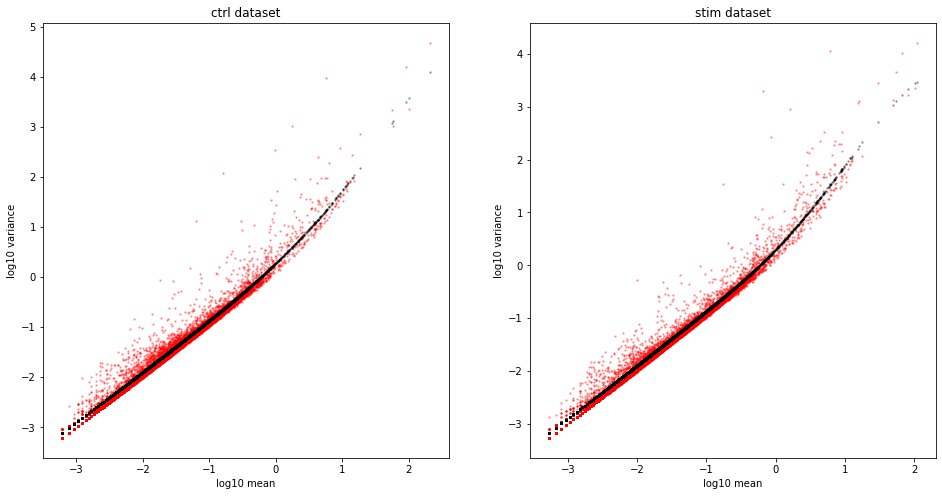

In [405]:
f, a = plt.subplots(1, 2, figsize =(16, 8))
a[0].scatter(lmg_c, lvg_c, c = "r", s = 2, alpha = .3)
a[0].scatter(lmg_c, lvs_c, c = "k", s = 2, alpha = .3)

a[1].scatter(lmg_s, lvg_s, c = "r", s = 2, alpha = .3)
a[1].scatter(lmg_s, lvs_s, c = "k", s = 2, alpha = .3)

a[0].set_title("ctrl dataset")
a[1].set_title("stim dataset")
for i in range(2):
    a[i].set_xlabel("log10 mean")
    a[i].set_ylabel("log10 variance")

In [395]:
"""
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

stim_cat = adata.obs["stim"].unique()
adata_list = [adata[adata.obs["stim"] == sc] for sc in stim_cat]
adata_list
"""

'\nsc.pp.normalize_total(adata, target_sum=1e4)\nsc.pp.log1p(adata)\n\nstim_cat = adata.obs["stim"].unique()\nadata_list = [adata[adata.obs["stim"] == sc] for sc in stim_cat]\nadata_list\n'

### Seurat CCA
We employ a variant of CCA, diagonal CCA, to account for cases where there are more cells than genes and apply this using the single-cell RNA-seq data sets as input

### MNN batch effect correction

##### implement the mnn correction for batch effects first and then the seurat cca function

The paper though introduces a lot of confusing and vague terminology and its a masterpiece in obfuscation

In [406]:
def cosine_normalize(rc):
    return rc / np.linalg.norm(rc, axis = 1)[:, None]

In [407]:
hvg0 = adata_ctrl_flt.var["hvg_sorted"][:3000]
hvg1 = adata_stim_flt.var["hvg_sorted"][:3000]
hvg = list(np.intersect1d(hvg0, hvg1))
print (len(hvg))

1222


In [408]:
adata_ctrl_hvg = adata_ctrl_flt[:,hvg]
adata_stim_hvg = adata_stim_flt[:, hvg]

In [409]:
rc_hvg_b0 = cosine_normalize(adata_ctrl_hvg.X.toarray())
rc_hvg_b1 = cosine_normalize(adata_stim_hvg.X.toarray())

In [410]:
gi = np.intersect1d(adata_ctrl_flt.var["features"].to_list(), adata_stim_flt.var["features"].to_list())

In [411]:
rc_b0 = cosine_normalize(adata_ctrl_flt[:, gi].X.toarray())
rc_b1 = cosine_normalize(adata_stim_flt[:, gi].X.toarray())

In [412]:
rc_hvg_ref = rc_hvg_b0
rc_ref = rc_b0


bi_hvg = rc_hvg_b1
bi = rc_b1

In [415]:
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
### might have to swap out this thingy for the fast nearest neighbor searches 

In [416]:
def get_mnn(rc_hvg_ref, bi_hvg, n_neighbors):
    
    ## for each bi, compute the mnn between ref and bi
    index_ref = cKDTree(rc_hvg_ref)
    index_bi = cKDTree(bi_hvg)
    dist_bi_to_ref, indices_bi_to_ref = index_ref.query(bi_hvg,    k = n_neighbors)
    dist_ref_to_bi, indices_ref_to_bi = index_bi.query(rc_hvg_ref, k = n_neighbors)
    mnn_ref = []
    mnn_bi = []
    for bi_node, ref_neighbors in tqdm(enumerate(indices_bi_to_ref)):
        ## check if any of ref_neighbors are in indices_ref_to_bi
        for rn in ref_neighbors:
            if bi_node in indices_ref_to_bi[rn]:
                mnn_ref.append(rn)
                mnn_bi.append(bi_node)
                
    return mnn_ref, mnn_bi, indices_bi_to_ref, indices_ref_to_bi

In [417]:
n_neighbors = 20

In [418]:
mnn_ref, mnn_bi, ind_bi_to_ref, ind_ref_to_bi = get_mnn(rc_hvg_ref, bi_hvg, n_neighbors)

7451it [00:00, 17082.24it/s]


In [419]:
### compute the batch vectors 
batch_vectors_hvg_ref_to_bi = rc_hvg_ref[mnn_ref] - bi_hvg[mnn_bi]
batch_vectors_all_ref_to_bi = rc_ref[mnn_ref] - bi[mnn_bi]

In [420]:
batch_vectors_hvg_ref_to_bi.shape, batch_vectors_all_ref_to_bi.shape

((11100, 1222), (11100, 12393))

In [421]:
## reduce the batch_vectors_hvg_ref_to_bi


In [422]:
mnn_bi_unq, mnn_bi_cnt = np.unique(mnn_bi, return_counts = True)

In [423]:
### average the batch vectors at the same index in bi
### i.e. have a shape of mnn_bi.shape[0] x hvg 
batch_vectors_hvg_ref_to_bi_red = np.zeros((bi_hvg.shape[0], batch_vectors_hvg_ref_to_bi.shape[1]))
for index, ve in zip(mnn_bi, batch_vectors_hvg_ref_to_bi):
    batch_vectors_hvg_ref_to_bi_red[index] += ve
batch_vectors_hvg_ref_to_bi_red = batch_vectors_hvg_ref_to_bi_red[mnn_bi_unq] / mnn_bi_cnt[:, None]

In [462]:
dist_mat = np.zeros((len(bi_hvg), len(kernel_cells_bi)))
for i, bh in tqdm(enumerate(bi_hvg)):
    for j, kc in enumerate(kernel_cells_bi):
        dist_mat[i, j] = np.dot(bh , kc)

In [ ]:
## total contribution of a kernel point to the entire dataset is normed to 1 
## so if thats too far away it doesnt adversely affect the results 

In [463]:
kernel_cells_bi = bi_hvg[mnn_bi_unq]
cdist_kernel_bi = dist_mat

sigma = 1.0
W = np.exp(-cdist_kernel_bi / sigma**2)
norm_W = np.sum(W[mnn_bi_unq], axis=0)
W = np.divide(W, norm_W)
denom_Wm = W.sum(axis = 1, keepdims = True)


In [469]:
W.shape, norm_W.shape, mnn_bi_unq.shape### across all kernel cells the probability is normalized to 1 
### and across all cells its normalized to 1 

((7451, 1833), (1833,), (1833,))

In [492]:
correction = np.divide(np.dot(W , batch_vectors_hvg_ref_to_bi_red), denom_Wm)

In [497]:
bi_corrected = bi_hvg + correction

In [434]:
corrected = mnnpy.mnn_correct(adata_ctrl_hvg, adata_stim_hvg, do_concatenate = False, var_adj=False)


Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...


/home/user-dnf/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Done.


In [483]:
corrected_mnnpy = corrected[0][1].X.toarray()

array([[ 0.00001207, -0.00002247,  0.00030707, ...,  0.00003268,
        -0.00001538,  0.00010187],
       [ 0.00000916, -0.00002378,  0.00034182, ...,  0.00003332,
        -0.00000494,  0.00011209],
       [ 0.00001171, -0.00002378,  0.00033741, ...,  0.0000445 ,
        -0.00001758,  0.00012099],
       ...,
       [ 0.00000989, -0.00002577,  0.00035307, ...,  0.00003647,
        -0.0000072 ,  0.00012651],
       [ 0.00001008, -0.00002174,  0.00032928, ...,  0.00005182,
        -0.00003217,  0.00014998],
       [ 0.00001266, -0.00002262,  0.00035557, ...,  0.00004068,
        -0.00001323,  0.0001155 ]], dtype=float32)